# Create different versions of Embeddings

## Version control

- V6.2 settings
    - Normal AE with Inception modules
    - No inception modules in the decoder
    - "Normal" meaning no latent variable layers
    - Simple MSEloss
- Difference to V6
    - ALL images rather than 500

## Interpretation of v.6.2 (AE with Inception modules, ALL 7798 images)
- Improved from v.6
- Increasing the number of images improves

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchviz import make_dot
import gc

In [4]:
def plot_images(path, character_ids):
    # just show first 10 images in 2x5 frame. This method could be made flexible, but there's no need
    rows, columns = 2, 5
    imgs = []
    character_ids = character_ids[:10+1]

    # get the actual images
    for id in character_ids:
        try:
            img = Image.open(path + str(id) + ".png")
            imgs.append(np.array(img))
        except:
            pass

    # iterate over axis and show
    fig, axes = plt.subplots(rows, columns, figsize=(8,4))
    for img, ax in zip(imgs, axes.flatten()):
        ax.imshow(img, cmap="gray")
    plt.show()

---
## Data Prep
---

In [5]:
# check file count
print(len(os.listdir("../assets/character_images/character_images_grayscale_ALL/")))

7797


In [6]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        character_id = self.target_imgs[idx].split(".")[0]
        # first is input to the model, second is input for reconstruction, third is the character_id for future ref
        return tensor_img, tensor_img, character_id

In [7]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * train_ratio)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    all_data_loader = DataLoader(manga_dataset, batch_size=batch_size)
    return train_loader, val_loader, all_data_loader

---
## AE with Inception modules
---

In [8]:
# Codes to build individual modules

# encoder modules
def single_encoder_module(in_c, out_c, k=1, s=1, p=0):
    module = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

def single_downsampling_module(in_c, pooling):
    module = nn.Sequential(nn.AvgPool2d(pooling),
                           nn.Conv2d(in_c, in_c*pooling, kernel_size=1),
                           nn.BatchNorm2d(in_c*pooling),
                           nn.ReLU(inplace=True))
    return module

In [9]:
# Inception modules

class EncoderInceptionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        bn_ch = channels // 2
        self.bottleneck = single_encoder_module(channels, bn_ch, 1)
        self.conv1 = single_encoder_module(bn_ch, channels, 1)
        self.conv2 = single_encoder_module(bn_ch, channels, 3, p=1)
        self.conv3 = single_encoder_module(bn_ch, channels, 5, p=2)
        self.conv4 = single_encoder_module(bn_ch, channels, 7, p=3)
        self.pool1 = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(5, stride=1, padding=2)

    def forward(self, x):
        bn = self.bottleneck(x)
        out = self.conv1(bn) + self.conv2(bn) + self.conv3(bn) + self.conv4(bn) + self.pool1(x) + self.pool2(x)
        return out

In [10]:
# Encoder and decoder modules
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # shallower version
        # self.up_ch1 = nn.Conv2d(1, 32, kernel_size=1)
        # self.e_incep1 = EncoderInceptionModule(32)
        # self.up_ch2 = single_downsampling_module(32, 4)
        # self.e_incep2 = EncoderInceptionModule(128)
        # self.up_ch3 = single_downsampling_module(128, 4)
        # self.e_incep3 = EncoderInceptionModule(512) # [8, 512, 12, 12]

        # deeper version
        self.up_ch1 = nn.Conv2d(1, 32, kernel_size=1)
        self.e_incep1 = EncoderInceptionModule(32)
        self.up_ch2 = single_downsampling_module(32, 2)
        self.e_incep2 = EncoderInceptionModule(64)
        self.up_ch3 = single_downsampling_module(64, 2)
        self.e_incep3 = EncoderInceptionModule(128)
        self.up_ch4 = single_downsampling_module(128, 2)
        self.e_incep4 = EncoderInceptionModule(256)
        self.up_ch5 = single_downsampling_module(256, 2)
        self.e_incep5 = EncoderInceptionModule(512)

    def forward(self, x):
        # print("x", x.shape)
        out = self.e_incep1(self.up_ch1(x))
        # print("e_incep1", out.shape)
        out = self.e_incep2(self.up_ch2(out))
        # print("e_incep2", out.shape)
        out = self.e_incep3(self.up_ch3(out))
        # print("e_incep3", out.shape)
        out = self.e_incep4(self.up_ch4(out))
        # print("e_incep4", out.shape)
        out = self.e_incep5(self.up_ch5(out))
        # print("e_incep5", out.shape)
        # out = F.avg_pool2d(out, 6)
        # out = self.flatten(out)
        return out


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.down_ch1 = single_upsampling_module_custom(512, 128, k=3, s=2)
        # self.down_ch2 = single_upsampling_module_custom(128, 32, k=3, s=2)
        # self.down_ch3 = single_upsampling_module_custom(32, 1, k=3, s=2, p=1)
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=1, stride=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, output_padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.sig5 = nn.Sigmoid()

    def forward(self, x):
        # print("decoder input", x.shape)
        out = self.relu1(self.conv1(x))
        # print("relu1", out.shape)
        out = self.relu2(self.conv2(out))
        # print("relu2", out.shape)
        out = self.relu3(self.conv3(out))
        # print("relu3", out.shape)
        out = self.relu4(self.conv4(out))
        # print("relu4", out.shape)
        out = self.relu5(self.conv5(out))
        # print("relu5", out.shape)
        out = self.sig5(out)
        # print("sig5", out.shape)
        return torch.sigmoid(out)

In [11]:
# AE model with inception modules
class AE_Inception(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

---
## Train
---

In [14]:
# !nvidia-smi

In [15]:
# version setting
version = "v6_2"

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

# visualize model
x = torch.zeros(8, 1, 200, 200, dtype=torch.float, requires_grad=False)
model = AE_Inception(device=device)
model.train()
model.to(device)
out = model(x.to(device))
make_dot(out, params=dict(list(model.named_parameters()))).render(version+"_inception_ae_torchviz", format="png")

'v6_2_inception_ae_torchviz.png'

In [17]:
# Putting training and validation into methods
def train_step(model, train_loader, optimizer, device):
    model.train()

    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        optimizer.zero_grad()
        out = model(train_img)
        loss = criterion(out, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # clean up
        del train_img, target_img, out
        gc.collect()

    avg_loss = running_loss / counter
    return avg_loss


def val_step(model, val_loader, device):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)
            out = model(train_img)
            loss = criterion(out, target_img)
            running_loss += loss.item()
            
            # clean up
            del train_img, target_img, out, loss
            gc.collect()

        avg_loss = running_loss / counter
        return avg_loss

In [18]:
# empty gpu cache
torch.cuda.empty_cache()

In [ ]:
# train and validate to check that the methods work

# redo the settings all again

# set data
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      # transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_ALL", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=32)


# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
model = AE_Inception(device=device)
model.train()
model.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(model.parameters())
optimizer = optim.Adam(ae_params, lr=0.001)

# train
losses = []

# check that it works
EPOCHS = 100
train_losses = []
val_losses = []
min_loss = 1e5

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train_step(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(model, val_loader, device=device)
    val_losses.append(val_loss)
    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

    # Save the best model
    if val_loss < min_loss:
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), "../assets/character_images/models_and_embeddings/best_model_"+version+".pt")
        min_loss = val_loss


cuda


  0%|                                                                                  | 0/100 [00:00<?, ?it/s]

In [ ]:
# plot training & validation losses
# print(train_losses[0:10])
plt.plot(train_losses,"g", val_losses, "r")
# plt.ylim(0.0, 1000000)
plt.show()

In [ ]:
# show what the model learned -> look how validation images are now represented by the decoder
# if the model learned the images well, they should look similar to each other

# Note: 
# when training loss doesn't go down (10 epochs, ~0.4 loss at minimum) -> dec_output is all BLACK and can't see anything
# when training loss goes down (50 epochs, ~0.04) -> dec_output is blurry but somewhat similar to the input

model.eval()
with torch.no_grad():
    for train_img, target_img, _ in val_loader:
        
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        out = model(train_img)
        
        # show only the first image of each batch (output original and decoder output images for comparison)
        for t_img, out_img in zip(train_img[0], out[0]):
            plt.imshow(t_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()
            plt.imshow(out_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()

---
## Create embedding
---

In [30]:
# create embedding

model.eval()
embedding = torch.zeros((1, 512, 12, 12))
character_ids = []
with torch.no_grad():
    for train_img, target_img, character_id in tqdm(all_data_loader):
        train_img = train_img.to(device)
        out = model.encoder(train_img).cpu()
        embedding = torch.cat((embedding, out), 0)
        character_ids.append(character_id)

100%|██████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


In [31]:
# Convert to numpy and save
character_ids = list(itertools.chain.from_iterable(character_ids))
np_character_ids = np.array(character_ids)
embedding = embedding[1:, :]
print("len of character_ids: ", len(character_ids))
print("shape of embedding: ", embedding.shape)
np_embedding = embedding.cpu().detach().numpy()
num_images = np_embedding.shape[0]

# Save the embeddings
flattened_embedding = np_embedding.reshape((num_images, -1))
print("shape of flattened embedding: ", flattened_embedding.shape)
np.save("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy", flattened_embedding)
np.save("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy", np_character_ids)

len of character_ids:  2000
shape of embedding:  torch.Size([2000, 512, 12, 12])
shape of flattened embedding:  (2000, 73728)


In [61]:
character_ids[100:110]

['40881',
 '81919',
 '83699',
 '200389',
 '279938',
 '22321',
 '6645',
 '261639',
 '79441',
 '41607']

---
## Similarity calculations (Character-based, Title-based)
---

In [32]:
class ImageBasedRecommendation:
    def __init__(self, query_path, version):
        print("model version: ", version)
        self.embedding_flat_np = np.load("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy") 
        self.embedding_ids = np.load("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy") 
        self.df_characters = pd.read_csv("../assets/characters_200p.csv")
        self.query_path = query_path

        # create character_based similarity matrix
        self.df_chara_sim_mat = pd.DataFrame(cosine_similarity(self.embedding_flat_np))
        self.df_chara_sim_mat.index = self.embedding_ids
        self.df_chara_sim_mat.columns = self.embedding_ids

        # create title_based similarity matrix
        np_embedding_id_concat = np.c_[self.embedding_ids.astype(int), self.embedding_flat_np] # create character_id:embeddings table
        df_embedding = pd.DataFrame(np_embedding_id_concat)
        df_embedding.rename(columns={0:"character_id"}, inplace=True)
        df_characters_unique = self.df_characters.drop_duplicates(subset="character_id") 
        df_title_char = df_characters_unique[["title_id", "character_id"]] # get character:title reference table
        df_merged = pd.merge(df_title_char, df_embedding, how="inner", on="character_id")
        df_title_embedding_avg = df_merged.groupby("title_id").mean() # merge and calculate "average" of image features
        self.df_title_sim_mat = pd.DataFrame(cosine_similarity(df_title_embedding_avg.iloc[:, 1:])) # similarity calculation of titles
        self.df_title_sim_mat.index = df_title_embedding_avg.index
        self.df_title_sim_mat.columns = df_title_embedding_avg.index

    def recommend_titles_from_similar_characters(self, query_character_id, top_n):
        # show the querying character
        df_q = self.df_characters[self.df_characters["character_id"]==query_character_id]
        print("Queried character: ", df_q["character_name"].unique(), " who appears in: ", df_q["title_romaji"].unique())
        img = Image.open(self.query_path + str(query_character_id) + ".png")
        plt.imshow(np.array(img), cmap="gray")
        plt.show()

        # get similar character
        df = self.df_chara_sim_mat[str(query_character_id)].sort_values(ascending=False)
        df_top = df[1:top_n+1]
        top_ids = list(df_top.index.astype(int))
        plot_images(self.query_path, top_ids)
        
        # print character names
        print("Similar characters (in the order of appearance)")
        for chara_id in top_ids:
            df_recc = self.df_characters[self.df_characters["character_id"]==int(chara_id)]
            print("Character: ", df_recc["character_name"].unique(), " who appears in : ", df_recc["title_romaji"].unique())

        # get titles that each similar character appears in
        df_res = self.df_characters[self.df_characters["character_id"].isin(top_ids)]
        df_res = df_res.drop_duplicates(subset="character_name")
        recc_title_ids = df_res["title_id"].unique()
        
        return recc_title_ids

    def recommend_titles_from_similar_image_embedding(self, query_title_id, top_n):
        # query title and pull out similar titles
        df = self.df_title_sim_mat[query_title_id].sort_values(ascending=False)
        df_top = df[0:top_n+1]
        top_ids = df_top.index

        # get images for comparison
        for idx, id in enumerate(top_ids):
            df = self.df_characters[self.df_characters["title_id"]==id]
            if idx == 0:
                print("Querying title: ", df["title_romaji"].unique())
            else:
                print("Similar title: ", df["title_romaji"].unique())
            character_ids = df["character_id"].unique()
            plot_images(self.query_path, character_ids)

        return list(top_ids[1:]) # exclude first element as it's the queried title


In [38]:
ibr_search = ImageBasedRecommendation("../assets/character_images/character_images_grayscale_ALL/", "v6_1")

model version:  v6_1


Queried character:  ['Mikasa Ackerman']  who appears in:  ['Shingeki no Kyojin' 'Shingeki no Kyojin: LOST GIRLS'
 'Shingeki! Kyojin Chuugakkou' 'Sungeki no Kyojin'
 'Shingeki! Kyojin Chuugakkou: Seishun! Tonari no Marley Gakuen']


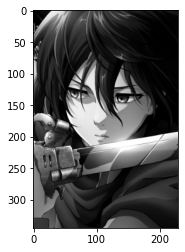

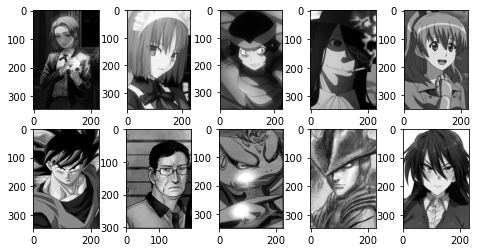

Similar characters (in the order of appearance)
Character:  ['Yoo-Sung Shin']  who appears in :  ['Jeonjijeok Dokja Sijeom']
Character:  ['Hisui']  who appears in :  ['Shingetsutan Tsukihime' 'Melty Blood' 'ALL AROUND TYPE-MOON' 'Take Moon'
 'Melty Blood X']
Character:  ['Sasamaru']  who appears in :  ['Sword Art Online']
Character:  ['Joker']  who appears in :  ['Enen no Shouboutai']
Character:  ['Seryuu Ubiquitous']  who appears in :  ['Akame ga Kill!' 'Akame ga Kill! 1.5']
Character:  ['Goku Son']  who appears in :  ['Dragon Ball' 'Dragon Ball Gaiden: Tensei-shitara Yamcha Datta Ken'
 'Ginga Patrol Jako' 'Cross Epoch' 'Dragon Ball Z: Fukkatsu no "F"'
 'Jump Super Stars' 'Neko Majin' 'Dragon Ball SD'
 'Dragon Ball Super: Broly'
 'Dragon Ball: Heya! Son Goku and His Friends Return!!'
 'Dragon Ball Minus: Hanatareta Unmei no Kodomo']
Character:  ['Shigemasa Kusunoki']  who appears in :  ['BTOOOM!']
Character:  ['Gamakichi']  who appears in :  ['NARUTO' 'Rock Lee no Seishun Full-Power N

In [63]:
res = ibr_search.recommend_titles_from_similar_characters(query_character_id=40881, top_n=10)
print(res)

Querying title:  ['MONSTER']


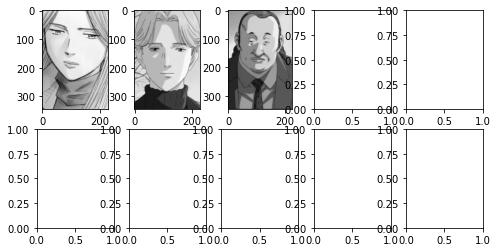

Similar title:  ['SPY×FAMILY']


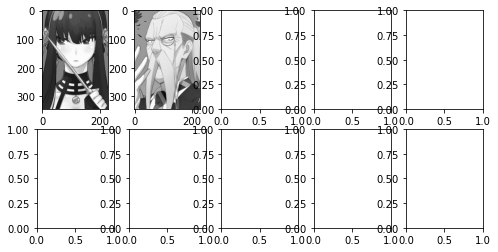

Similar title:  ['BECK']


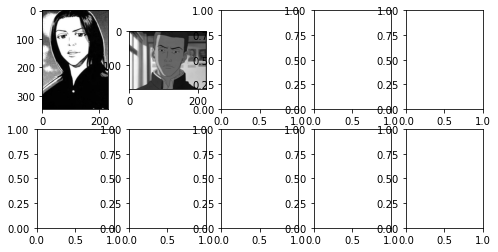

Similar title:  ['NARUTO']


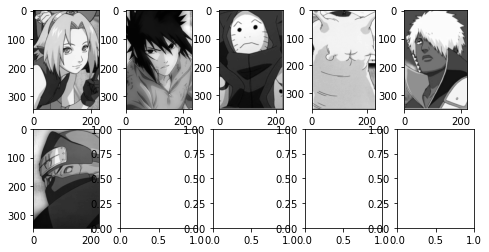

[108556, 30145, 30011]


In [64]:
res = ibr_search.recommend_titles_from_similar_image_embedding(query_title_id=30001, top_n=3)
print(res)